In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

# 1. 앙상블

In [2]:
# 앙상블(ensemble): 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법
# 앙상블 모델 중 랜덤 포레스트(random forest), 그래디언트 부스팅(gradient boosting)
# 결정 트리 모델이 분류와 회귀 문제의 다양한 데이터셋에서 효과적이라고 입증됨

# 2. 랜덤 포레스트

In [3]:
# 랜덤 포레스트는 결정 트리의 주요 단점인 training data에 과대적합되는 경향을 회피할
# 수 있는 방법
# 랜덤 포레스트: 여러 결정 트리의 묶음
#  - 서로 다른 방향으로 과대적합된 트리를 많이 만들어 그 결과를 평균냄
#  - 트리들이 달라지도록 트리 생성 시 무작위성을 주입한다.
#  - 트리를 랜덤하게 만드는 방법
#    1) 트리를 만들 때 사용하는 데이터 포인트를 무작위로 선택하는 방법
#    2) 분할 테스트에서 특성을 무작위로 선택하는 방법

## 2-1. 랜덤 포레스트 구축

In [4]:
# 1. 생성할 트리의 개수를 정해야 한다. (RandomForestRegressor나 
#    RandomForestClassifier의 n_esimators 매개변수)
# 2. 데이터의 부트스트랩 샘플(bootstrap sample) 생성
#  - n_samples개의 데이터 포인트 중 무작위로 데이터를 n_samples 횟수만큼 반복 추출
#  - 이 데이터셋은 원래 데이터셋 크기와 같지만, 어떤 데이터 포인트는 누락될 수도 있고
#   (대략 1/3 정도), 어떤 데이터 포인트는 중복되어 들어 있을 수 있다.
#  - 예) 리스트 ['a', 'b', 'c', 'd']에서 부트스트랩 샘플 만들면
#       ['b', 'd', 'd', 'c']도 ['d', 'a', 'd', 'a']도 만들어질 수 있다.
# 3. 이렇게 만든 데이터셋으로 결정 트리를 만듬
#  - 이전의 결정 트리 알고리즘과 조금 다름
#  - 각 노드에서 전체 특성을 대상으로 최선의 테스트를 찾는 것이 아님
#  - 각 노드에서 후보 특성을 랜덤하게 선택한 후 이 후보들 중 최선의 테스트를 찾는다.
#  - 몇 개의 특성을 고를지는 max_features 매개변수로 조정 가능
#  - 후보 특성을 고르는 것은 매 노드마다 반복되므로 트리의 각 노드는 다른 후보 특성들을
#    사용하여 테스트를 만든다.
#  - 두 메커니즘이 합쳐져서 랜덤 포레스트의 모든 트리가 서로 달라진다.
#    1) 부트스트랩 샘플링이 각 트리가 조금씩 다른 데이터셋을 이용해 만들어지도록 한다.
#    2) 각 노드에서 특성의 일부만 사용하기 때문에 트리의 각 분기는 각기 다른 특성 부분
#       집합을 사용한다.
#     - max_features를 n_features로 설정하면 트리의 각 분기에 모든 특성을 고려하므로
#       특성 선택에 무작위성이 들어가지 않는다.(하지만 부트스트랩 샘플링으로 인한
#       무작위성으 그대로이다.)
#     - max_features=1로 설정하면 트리의 분기는 테스트할 특성을 고를 필요가 없어
#       무작위로 선택한 특성의 임계값을 찾기만 하면 된다.
#     - max_features 값을 크게하면 랜덤 포레스트 트리들은 매우 비슷해지고 가장 두드러진
#       특성을 이용해 데이터에 잘 맞춰질 것이다.
#     - max_features를 낮추면 트리들은 많이 달라지고 각 트리는 데이터에 맞추기 위해
#       깊이가 깊어지게 된다.

# 예측할 때는 먼저 알고리즘이 모델에 있는 모든 트리의 예측을 만든다.
# 회귀에서: 이 예측들을 평균하여 최종 예측을 만듬
# 분류에서: 약한 투표 전략을 사용한다. 
#           즉 각 알고리즘은 가능성 있는 출력 레이블의 확률을 제공함으로써 간접적인
#           예측을 한다.
#           트리들이 예측한 확률을 평균내어 가장 높은 확률을 가진 클래스가 예측값이
#           된다.

## 2-2. 랜덤 포레스트 분석

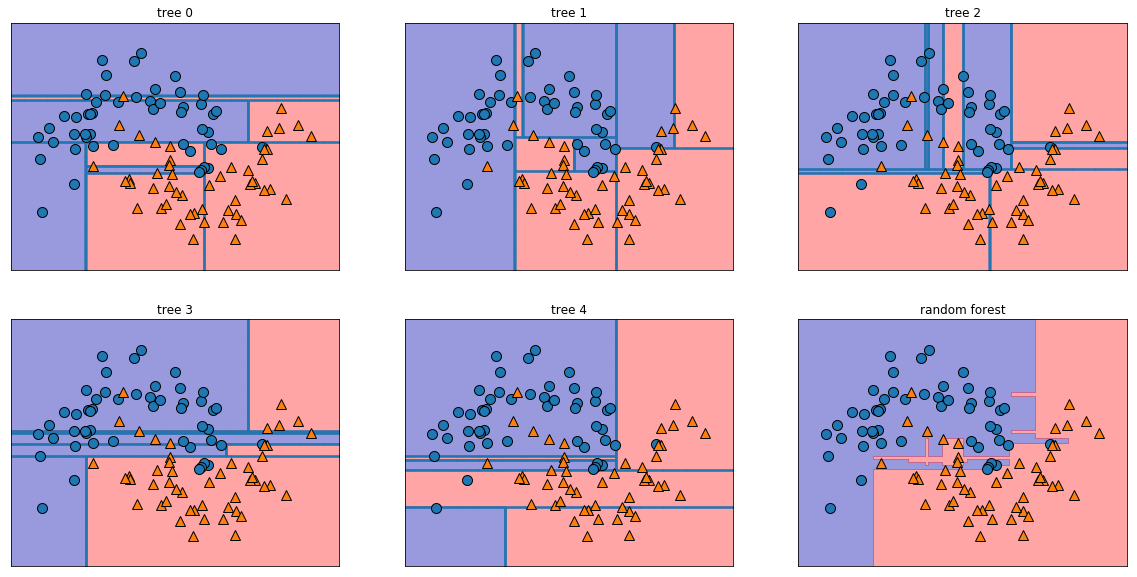

In [15]:
# 각 트리에서 학습된 결정 경계와 취합해 만든 결정 경계 시각화
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("tree {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("random forest")
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# 다섯 개의 트리가 만든 결정 경계는 확연히 다르고, 부트스트랩 샘플링 때문에 한쪽
# 트리에 나타나는 훈련 포인트가 다른 트리에는 포함되지 않을 수 있어 각 트리는 불완전

# 랜덤 포레스트는 개개의 트리보다는 덜 과대적합되고 훨씬 좋은 결정 경계를 만듬

In [18]:
# 유방암 데이터셋에 100개 트리로 이뤄진 랜덤 포레스트 적용
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("training set 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("test set 정확도: {:.3f}".format(forest.score(X_test, y_test)))

# 랜덤 포레스트는 매개변수 튜닝없이도 선형 모델이나 단일 결정 트리보다 높은 정확도를
# 보여준다.
# 단일 결정 트리처럼 max_features를 조정하거나 사전 가지치기도 가능

training set 정확도: 1.000
test set 정확도: 0.972


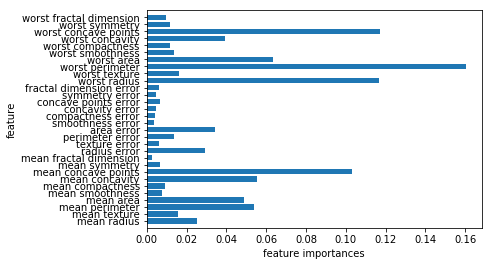

In [21]:
# 랜덤 포레스트 특성 중요도
# 각 트리의 특성 중요도를 취합하여 계산한다.
# 랜덤 포레스트의 특성 중요도가 하나의 트리에서 제공하는 것보다 더 신뢰할 만하다.

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("feature importances")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(forest)

# 단일 결정 트리보다 훨씬 많은 특성이 0 이상의 중요도 값을 갖는다.
# 랜덤 포레스트도 "worst radius" 특성이 매우 중요하다고 보지만, 가장 많은 정보를 가진
# 특성으로는 "worst perimeter"를 선택함
# 무작위성은 알고리즘이 가능성 있는 경우를 고려할 수 있도록 하므로,
# 단일 트리보다 더 넓은 시각으로 데이터를 바라볼 수 있다.

## 2-3. 장단점과 매개변수

In [22]:
# 회귀, 분류에 있어서 가장 널리 사용되는 머신러닝 알고리즘
# 성능이 매우 뛰어나고 매개변수 튜닝을 많이 하지 않아도 잘 작동
# 데이터 스케일을 맞출 필요 없음

# 결정 트리보다 더 깊어지는 경향이 있다. 그러므로 비전문가에게 예측 과정을 시각적으로
# 보여주려면 하나의 결정 트리가 더 좋은 선택이다.

# 대량의 데이터셋에서 랜덤 포레스트는 시간이 다소 걸릴 수 있지만 CPU 코어가 많다면
# 손쉽게 병렬 처리 가능(n_jobs 매개변수로 CPU 코어 개수 지정)
# n_jobs = -1로 지정하면 컴퓨터의 모드 코어를 사용한다.(기본값 1)

# 다른 random_state를 지정하면(또는 지정하지 않으면) 전혀 다른 모델 만들어짐
# 트리가 많을수록 random_state 값의 변화에 따른 변동이 적다.
# 같은 결과를 만들어야 한다면 random_state 값 고정

# 텍스트 데이터 같은 매우 고차원이고 희소한 데이터에는 잘 작동하지 않음
# 선형 모델이 더 적합

# 선형 모델보다 많은 메모리를 사용
# 훈련과 예측이 느림
# 속도와 메모리 사용에 제약있는 어플리케이션이라면 선형 모델 더 적합할 수 있다.

# 주요 매개변수
# n_estimators, max_features, max_depth
# 결정 트리와 마찬가리로 max_leaf_nodes, min_samples_leaf, min_samples_split도 제공
# n_esimators는 클수록 좋다. 더 많은 트리를 평균하면 과대적합을 줄여 더 안정적인 모델을
# 만듬
# 하지만 더 많은 트리는 더 많은 메모리와 긴 훈련 시간이 걸린다.
# max_features는 각 트리가 얼마나 무작위가 될지를 결정
# 작은 max_features는 과대적합을 줄여준다.
# 일반적으로 기본값이 좋다.
# 분류: max_features=sqrt(n_features)(RandomForestClassifier 기본값)
# 회귀: max_features=n_features(RandomForestRegressor 기본값)
# max_features나 max_leaf_nodes 매개변수를 추가하면 가끔 성능이 향상되고 훈련과 예측에
# 필요한 메모리와 시간을 많이 줄일 수도 있다.

# 3. 그래디언트 부스팅 회귀 트리

In [23]:
# 그래디언트 부스팅 회귀 트리: 여러 개의 결정 트리를 묶은 또 다른 앙상블 방법
# 이름이 회귀이지만 회귀, 분류 모두 사용 가능
# scikit-learn의 GradientBoostingClassifier와 GradientBoostingRegressor 모두
# 회귀 트리인 DecisionTreeRegressor를 사용하여 그래디언트 부스팅을 구현하고 있다.

# 랜덤 포레스트와 달리 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듬
# 이전에 만든 트리의 예측과 target값 사이의 오차를 줄이는 방향으로 새로운 트리 추가
# 이를 위해 손실 함수를 정의하고 경사 하강법(gradient descent)을 사용하여 다음에
# 추가될 트리가 예측해야 할 값을 보정해 나간다.
# 기본적으로 무작위성이 없다.
# 대신 강력한 사전 가지치기가 사용된다.

# 보통 1 ~ 5 정도의 깊지 않은 트리를 사용하므로 메모리를 적게 사용하고 예측도 빠름
# 아이디어: 얕은 트리 같은 간단한 모델(약한 학습기, weak learner)을 많이 연결하는 것
# 각 트리는 데이터의 일부에 대해서만 예측을 잘 수행할 수 있어 트리가 많이 추가될수록
# 성능이 좋아짐
# 머신러닝 경연 대회에서 우승을 많이 차지, 업계에서도 널리 사용
# 랜덤 포레스트보다 매개변수 설정에 조금 더 민감하지만 잘 조정하면 더 높은 정확도 제공

# 앙상블 방식의 사전 가지치기, 트리 개수 외 그래디언트 부스팅에서 중요한 매개변수
# : 이전 트리의 오차를 얼마나 강하게 보정할 것인지 제어하는 learning_rate
# 학습률이 크면 트리는 보정을 강하게 하여 복잡한 모델을 만든다.
# n_estimators값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고
# training set에서의 실수를 바로잡을 기회가 더 많아짐

In [24]:
# 유방암 데이터셋을 이용한 GradientBoostingClassifier
# 깊이 3, 트리 100개, 학습률 0.1
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("training set 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

# training set 정확도가 100%이므로 과대적합

training set 정확도: 1.000
test set 정확도: 0.958


In [31]:
# 과대적합을 막기 위해 트리의 최대 깊이를 줄여 사전 가지치기를 강하게 하거나
# 학습률을 낮출 수 있다.

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("training set 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
print()

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("training set 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

# 두 방식은 모델의 복잡도를 감소시키므로 training set의 정확도가 낮아졌다.
# 여기에서 학습률 낮추는 것은 test set 성능을 조금밖에 개선 못했지만, 최대 깊이를
# 낮추는 것은 모델 성능 향상에 크게 기여했다.

training set 정확도: 0.991
test set 정확도: 0.972

training set 정확도: 0.988
test set 정확도: 0.965


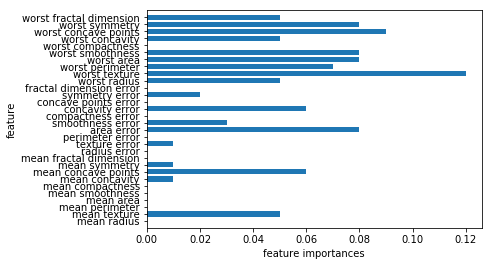

In [32]:
# 특성 중요도 시각화

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

# 랜덤 포레스트의 특성 중요도와 비슷
# 단 그래디언트 부스팅은 일부 특성 완전히 무시

# 비슷한 종류의 데이터에서 그래디언트 부스팅, 랜덤 포레스트 둘 다 잘 작동하지만
# 보통 더 안정적인 랜덤 포레스트를 먼저 적용하곤 한다.
# 랜덤 포레스트가 잘 작동하더라도 예측 시간이 중요하거나 머신러닝 모델에서 마지막
# 성능까지 쥐어짜야 할 때 그래디언트 부스팅을 사용하면 도움이 된다.

# 대규모 머신러닝 문제에 그래디언트 부스팅을 적용하려면 xgboost 패키지와 파이썬
# 인터페이스를 검토해보는 것이 좋다.

# * xgboost: 대용량 분산 처리를 위한 그래디언트 부스팅

## 3-1. 장단점과 매개변수

In [ ]:
# 그래디언트 부스팅 결정 트리는 지도 학습에서 가장 강력하고 널리 사용하는 모델 중 하나

# 단점
# 1) 매개변수를 잘 조정해야 한다. 
# 2) 훈련 시간이 길다
# 3) 트리 기반 모델 특성상 희소한 고차원 데이터에는 잘 작동하지 않는다.

# 장점
# 1) 다른 트리 기반 모델처럼 특성의 스케일을 조정하지 않아도 된다.
# 2) 이진 특성이나 연속적인 특성에서도 잘 동작한다.

# 매개변수
# 1) 트리의 개수를 지정하는 n_estimators
# 2) 이전 트리의 오차를 보정하는 정도를 조절하는 learning_rate
# * 이 두 매개변수는 매우 깊게 연관되며 learning_rate를 낮추면 비슷한 복잡도의 모델을
#   만들기 위해 더 많은 트리를 추가해야 한다.
# * n_estimators가 클수록 좋은 랜덤 포레스트와 달리 모델이 복잡해지고 과대적합될
#   가능성이 높다.
# * 일반적인 관례는 가용한 시간과 메모리 한도에서 n_estimators를 맞추고 나서 적절한
#   learning_rate를 찾는 것
# 3) 각 트리의 복잡도를 낮추는 max_depth(또는 max_leaf_nodes)
#  - 통상 그래디언트 부스팅 모델에서는 amx_depth를 매우 작게 설정하며, 트리 깊이가
#    5보다 깊어지지 않게 한다.
